In [193]:
import pandas as pd 
import numpy as np
import pandas_datareader as pdr 
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
pd.options.display.float_format = '{:,.2f}'.format

# GARCH (1, 1)
### create GARCH function & use Max Likelihood Estimation to find optimal parameters.

### Implementation: 
1st data period squared return used for estimation of variance (var0) for the second period 
estimated variance for the second period (var0) and return in the second period are used for estimating variance for third period
for coding purposes we will refer to the first instances of varinace and return as var0 and return0, respectively, despite they are 
estimated in different intervals (first period, second period respectively).
Therefore, the first period GARCH full recursive formula is applied to is the third period, based on variance estimate for 
the second period, and realized return in the second period.
First implementation of the recursive formula is for the period between 2nd and 3rd starting date, whereas the first variance estimate (var0) is forecasting variance for the period between starting_dates[1] and starting_dates[2]  

    create out of sample monthly forecast.
    on portfolio rebalancing days, use daily estimated variance for the rebalancing days, and based on it create estimate for the next 21 days, average them, 
    and use it as a variance estimate for the period.
    VL + (alpha + beta)^k*(var - VL) for k in range (1, 22))
    where VL is long term variance and var is estimated variance for the rebalancing day

### variance = omega + alpha * return(n-1)^2 + beta * variance(n-1)

In [194]:
def GARCH (X, df_CCR, start):
    """""
    X = [alpha, beta]
    omega = long run var * (1-alpha-beta)
    long run var - estimated as a mean of the squared returns during the five year period
    df_CCR - data with continiously compounded returns
    """""
    market_return = df_CCR['^GSPC']
    daily_return = market_return.iloc[int(np.argwhere(market_return.index==start))-2 : ]
    VL = np.mean(daily_return**2) #estimate of long term daily variance. as recommended by John Hull 'variance targeting'
    var0 = (daily_return[0])**2 ## first period used to estimate var 0 (daily variance )
    omega = VL * (1 - X[0] - X[1])

    var = [var0]
    for i in range(len(daily_return)-1):
        var.append(float(omega + X[0] * daily_return[i+1]**2 + X[1] * var[i]))
    data = pd.concat([pd.Series (var[:-1], index=daily_return[1:].index), daily_return[1:]], axis=1, sort=False)
    data.columns= ['Var', 'Return']
    data['Log'] = -np.log(data['Var']) - (data['Return']**2) / (data['Var'])
    return data

In [195]:
def optimize_parameters (df_CCR, start):
    """""
    df_CCR - data with continiously compounded returns, starting date earlier than 'start', ending date won't be adjusted in the code. Has to be managed separately.
    """""  
    import scipy
    from scipy.optimize import minimize

    f = lambda x: -1 * np.sum(GARCH(x, df_CCR, start)['Log']) ### 0 is dataframe, 1 is long term volatility

    # Define the constraints for our minimizer
    def constraint1(X):
        return np.array([1 - (X[0] + X[1])])

    def constraint2(X):
        return np.array([X[0]])

    def constraint3(X):
        return np.array([X[1]])


    cons = ({'type': 'ineq', 'fun': constraint1},
            {'type': 'ineq', 'fun': constraint2},
            {'type': 'ineq', 'fun': constraint3})

    result = scipy.optimize.minimize(f, (0.13, 0.86),
                            method='SLSQP',
                            constraints = cons)
    return result.x

In [196]:
def GARCH2 (X, df_CCR, start):
    """""
    X = [alpha, beta, VL]
    omega = long run var * (1-alpha-beta)
    long run var - estimated as a mean of the squared returns during the five year period
    df_CCR - data with continiously compounded returns
    """""
    alpha = X[0]
    beta = X[1]
    VL = X[2]
    omega = VL * (1 - alpha - beta)
    market_return = df_CCR['^GSPC']
    daily_return = market_return.iloc[int(np.argwhere(market_return.index==start))-2 : ]
    var0 = (daily_return[0])**2 ## first period used to estimate var 0 (daily variance )

    var = [var0]
    for i in range(len(daily_return)-1):
        var.append(float(omega + alpha * daily_return[i+1]**2 + beta * var[i]))
    data = pd.concat([pd.Series (var[:-1], index=daily_return[1:].index), daily_return[1:]], axis=1, sort=False)
    data.columns= ['Var', 'Return']
    data['Log'] = -np.log(data['Var']) - (data['Return']**2) / (data['Var'])
    return data

In [201]:
def out_of_sample_G (test, rebalancing_dates, X):
    """""
    test - daily GARCH estimate
    rebalancing dates - points where we have to create out of sample forecast
    """""
    alpha = X[0]
    beta = X[1]
    VL = X[2]
    estimate_basis = test['Var'][rebalancing_dates]
    k=np.arange(1, 22)
    var = pd.Series (index=estimate_basis.index)
    estimates = pd.Series (index=np.arange(len(k)))
    for i in range (len(estimate_basis)):
        for z in range (len(k)):     
            estimates[z] = (VL + (alpha + beta)**k[z] * (estimate_basis[i] - VL))
        var[i] = np.mean(estimates)
    return np.sqrt (var*252)

In [202]:
%store -r starting_dates1
start = []
i = 0
while i<=20:
    start.append(starting_dates1[starting_dates1.year == starting_dates1.year.unique()[i]][-1])
    i+=5

In [220]:
def estimate (start, years, df, starting_dates1):
    """""
    start - starting dates of intervals where new GARCH estimates (alpha, beta, omega) will be used
    years - number of years before starting date, which will be used for estimating GARCH parameters for out of sample testing
        
    example: 
    estimate (start = [Timestamp('1999-12-31 00:00:00'), Timestamp('2004-12-07 00:00:00'), Timestamp('2009-12-08 00:00:00')], years = 5, df)
    """""
    x = input("If you want to check paramteres, type 'Parameters', otherwise press enter (go immediately to estimates)")
    
    # later used for out of sample testing
    rebalancing_dates = {}
    for i in range(len(start)-1):
        rebalancing_dates[i] = (starting_dates1[(starting_dates1>=start[i])*(starting_dates1<start[i+1])]) 

    # creating dataframes necessary for doing the tests
    df_ = {}
    for i in range(len(rebalancing_dates)):
        df_[i] = pd.DataFrame (data = df[df.index<rebalancing_dates[i][0]])

    # calculating optimal parameters for specific intervals
    parameters = pd.DataFrame(index = np.arange(len(df_)), columns = ['Alpha', 'Beta', "VL"])
    for i in range (len(df_)):
        date = df_[i][df_[i].index.year == (rebalancing_dates[i][0].year-years)].iloc[-1:].index[0] # our sample spreads 5 years before rebalancing data
        res = optimize_parameters(df_[i], date)
        parameters.iloc [[i], [0]] = res[0]
        parameters.iloc [[i], [1]] = res[1]
        parameters.iloc [[i], [2]] = np.mean((df_[i]['^GSPC'].iloc [int (np.argwhere(df_[i]['^GSPC'].index == date))-2:])**2)

    # dataframe necessary for testing
    df_test = {}
    for i in range (1, len (start)):
        df_test[i-1] = df[df.index<start[i]]

    # creating the forecast based on the optimal parameters and past returns
    results = {}
    for i in range (len(parameters)):
        test = GARCH2(parameters[i:i+1].T[i], df_test[i], start[i])
        results[i] = out_of_sample_G (test, rebalancing_dates[i], parameters[i:i+1].T[i])
    
    if x == 'Parameters':
        return parameters
    else:
        return pd.concat([results[i] for i in range (len(results))])

In [204]:
df1 = pd.read_csv('Data//^GSPC.csv')
df1 = df1.set_index('Date')
df1.index = pd.to_datetime(df1.index)
df1 = np.log(df1) - np.log(df1.shift(1))
df1.columns = ['^GSPC']

In [208]:
start = []
i = 0
while i<=20:
    start.append(starting_dates1[starting_dates1.year == starting_dates1.year.unique()[i]][-1])
    i+=20
start

[Timestamp('1999-12-31 00:00:00'), Timestamp('2019-12-12 00:00:00')]

In [18]:
parms = estimate(start, 15, df1)

If you want to check paramteres, type 'Parameters', otherwise press enter (go immediately to estimates) Parameters


In [24]:
garch_vol = estimate(start, 15, df1)

If you want to check paramteres, type 'Parameters', otherwise press enter (go immediately to estimates) 


In [21]:
%store -r realized ### NOTEBOOK VIX

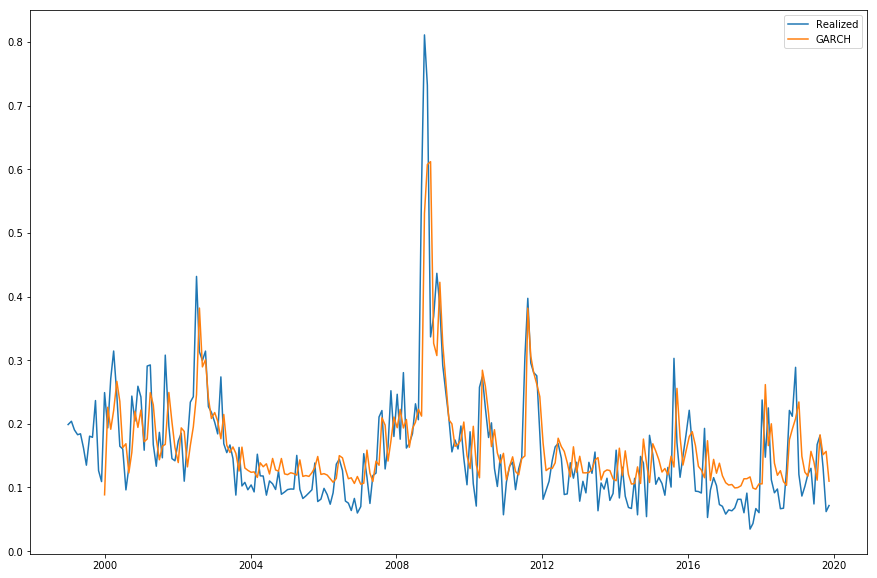

In [25]:
fig,ax = plt.subplots(figsize = (15, 10))
ax.plot(realized, label = "Realized")
ax.legend()
ax.plot(garch_vol, label = "GARCH")
ax.legend()
plt.show()

In [26]:
%store garch_vol

Stored 'garch_vol' (Series)


## Use 5 years of data to estimate parameters before each start date, and apply them in out of sample period. New parameters calculated on a 5 year basis. 

In [211]:
start = []
i = 0
while i<=20:
    start.append(starting_dates1[starting_dates1.year == starting_dates1.year.unique()[i]][-1])
    i+=5
start

[Timestamp('1999-12-31 00:00:00'),
 Timestamp('2004-12-07 00:00:00'),
 Timestamp('2009-12-08 00:00:00'),
 Timestamp('2014-12-10 00:00:00'),
 Timestamp('2019-12-12 00:00:00')]

In [212]:
garch_vol1 = estimate(start, 5, df1)

If you want to check paramteres, type 'Parameters', otherwise press enter (go immediately to estimates) 


In [214]:
%store garch_vol1

Stored 'garch_vol1' (Series)


In [216]:
%store -r starting_dates2

In [224]:
start = []
i = 0
while i<=25:
    start.append(starting_dates2[starting_dates2.year == starting_dates2.year.unique()[i]][-1])
    i+=5
start

[Timestamp('1994-12-05 00:00:00'),
 Timestamp('1999-12-31 00:00:00'),
 Timestamp('2004-12-07 00:00:00'),
 Timestamp('2009-12-08 00:00:00'),
 Timestamp('2014-12-10 00:00:00'),
 Timestamp('2019-12-12 00:00:00')]

In [225]:
garch_vol1995 = estimate(start, 5, df1, starting_dates2)

If you want to check paramteres, type 'Parameters', otherwise press enter (go immediately to estimates) 


In [226]:
%store garch_vol1995

Stored 'garch_vol1995' (Series)
